# Accelerating Benders Decomposition

Author: Mathieu Tanneau, mtanneau3@gatech.edu

This notebook illustrates various acceleration techniques for Benders decomposition,
    on artificial instances of the uncapacitated facility location problem.

The notebook is released under the following terms:
* the _code_ is released under the [MIT license](https://mit-license.org/)
* the _text_ is released under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/)

### Julia & compilation

Julia code is compiled the first time it is executed.
Thus, it is recommended to always execute code twice, to ensure the reported time does not include any compilation.

For further details, see the [Julia documentation](https://docs.julialang.org/en/v1/) and its [Performance tips section](https://docs.julialang.org/en/v1/manual/performance-tips/).

In [1]:
# Activate the Julia environment defined in the Project.toml file
using Pkg
Pkg.activate(".")

# The following line ensures that all packages are installed
# You can comment it out if you've already run this notebook at least once.
Pkg.instantiate()  

In [2]:
# Load standard library packages
using BenchmarkTools
using LinearAlgebra
using Printf
using Random

using Plots

# JuMP is a modeling language embedded in Julia
# For more details: https://jump.dev/
using JuMP

# Gurobi (https://gurobi.com) is a commercial solver; you need to download it manually.
# Then, follow installation instructions at https://github.com/jump-dev/Gurobi.jl#installation
using Gurobi
# To avoid checking out multiple Gurobi licenses, we define a global Gurobi environment,
#   which will be re-used throughout the code.
if !isdefined(Main, :GRBENV)  # Avoid re-defining a const
    const GRBENV = Gurobi.Env()
end

# HiGHS (https://github.com/ERGO-Code/HiGHS) is an open-source solver.
# Julia's package manager will automatically download and install HiGHS.
using HiGHS

Academic license - for non-commercial use only - expires 2022-07-04


# Uncapacitated Facility Location

This problem is a classical example for applying Benders decomposition.

## Problem data

The problem data is composed of
* $m$ sites where facilities may be built
* $n$ customers to be served
* the location of each customer and potential site

In [3]:
m = 8   # Number of sites
n = 32  # Number of customers

# To ensure reproducibility, always use a seed!
Random.seed!(1804)

# Generate coordinates for customers and sites
# To introduce some symmetries, all coordinates lay on a grid
grid_param = 50

Xc = rand(0:grid_param, n, 2) ./ grid_param  # Customer coordinates
Xf = rand(-1:21, m, 2) ./ 20                 # Facility coordinates
;

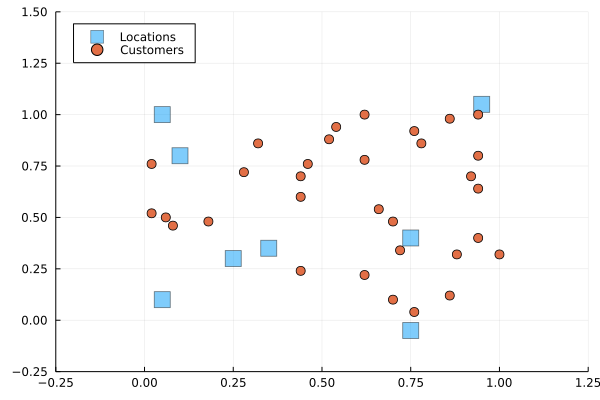

In [4]:
# Since we have coordinates, we can visualize what the instance looks like
plt = plot(
    legend=:topleft,
    xlim=(-0.25, 1.25),
    ylim=(-0.25, 1.5),
)

scatter!(plt, Xf[:, 1], Xf[:, 2], label="Locations", marker=:rect, ms=8, opacity=0.5)
scatter!(plt, Xc[:, 1], Xc[:, 2], label="Customers", marker=:circ, ms=5)

## Mathematical formulation

### Decision variables

\begin{align*}
    y_{i} &= 
    \left\{
       \begin{array}{cl}
           1 & \quad \text{if a facility is built at location $i$},\\
           0 & \quad \text{otherwise}
       \end{array}
    \right.
        && \forall i \in \{1, ..., m \},\\
       \ \\
    x_{i, j} &= 
    \left\{
       \begin{array}{cl}
           1 & \quad \text{if customer $j$ is served by facility $i$},\\
           0 & \quad \text{otherwise}
       \end{array}
       \right.
        &&\forall (i, j) \in \{1, ..., m \} \times \{1, ..., n\}
\end{align*}

### Constraints

* Each customer must be served by exactly one facility:
\begin{align*}
    \sum_{i} x_{i, j} & = 1, && \forall j = \{1, ..., n\}.
\end{align*}
* A facility can only serve a customer if it has been built:
\begin{align*}
    x_{i, j} & \leq y_{i}, && \forall (i,j) \in \{1, ..., m\} \times \{1, ..., n\}.
\end{align*}
* All variables are binary
\begin{align*}
    y & \in \{0, 1\}^{m},\\
    x & \in \{0, 1\}^{m \times n}.
\end{align*}

### Objective 

The objective (to be minimized) reads
\begin{align*}
    f^{T}y + \sum_{i, j} D_{i, j} x_{i, j},
\end{align*}
where
* $f_{i}$ is the cost of building a facility at location $i$,
* $D_{i, j}$ is the distance between location $i$ and customer $j$.

In [5]:
# Sample fixed building costs
f = rand(10:20, m)

# Compute distance matrix
D = zeros(Float64, m, n)
for j in 1:n, i in 1:m
    D[i, j] = norm(Xf[i, :] - Xc[j, :], 2)
end
# Increase the distances to make the problem a little harder
D .*= 10
;

# MIP formulation

The overall problem reads

\begin{align}
    \min_{x, y} \quad
    & \sum_{i} f_{i} y_{i} + \sum_{i, j} D_{i, j} x_{i, j}\\
    \text{s.t.} \quad
    & \sum_{i} x_{i, j} = 1, && \forall j,\\
    & x_{i, j} \leq y_{i}, && \forall (i, j),\\
    & y \in \{0, 1\}^{m},\\
    & x \in \{0, 1\}^{m \times n}.
\end{align}

Small instances can be solved efficiently with off-the-shelf MIP solvers.

In [ ]:
mip = Model()  # You can defined a JuMP model without a solver...

# Decision variables
@variable(mip, y[1:m], Bin)
@variable(mip, x[1:m, 1:n], Bin)

# Constraints
@constraint(mip, customer_served[j in 1:n], sum(x[:, j]) == 1)
@constraint(mip, facility_open[i in 1:m, j in 1:n], x[i, j] <= y[i])

# Objective function
@objective(mip, Min, dot(f, y) + dot(D, x))

# ... and attach a MIP solver afterwards
# Un-comment the line you want, to choose the corresponding MIP solver
set_optimizer(mip, Gurobi.Optimizer)  # Gurobi is much faster on large instances
# set_optimizer(mip, HiGHS.Optimizer)

optimize!(mip)

sname = solver_name(mip)
stime = solve_time(mip)

println("$(sname) solved the problem in $(stime) seconds.")

In [ ]:
# Get the optimal solution value...
y_ = Bool.(round.(value.(mip[:y])))
x_ = Bool.(round.(value.(mip[:x])))

println("There are $(sum(y_)) facilities open.")

# ... and plot it
plt = plot(
    title="$(sname) solution",
    legend=:bottomleft,
    ylim=(-0.25, 1.25),
)

# Show which customer is served by which facility
for i in 1:m
    for j in 1:n
        if x_[i, j]
            # Plot a line between yi and xj
            plot!(plt, [Xc[j, 1], Xf[i, 1]], [Xc[j, 2], Xf[i, 2]], label=nothing, lw=0.5, color=:black)
        end
    end
end

# Customers
scatter!(plt, Xc[:, 1], Xc[:, 2], label="Customers", marker=:circ, ms=4, color=:red)

# Facilities (open and closed)
scatter!(plt, [Xf[.! y_, 1]], [Xf[.!y_, 2]],
    color=:lightblue,
    label="Facilities (closed)",
    marker=:rect,
    ms=6
)
scatter!(plt, [Xf[y_, 1]], [Xf[y_, 2]],
    color=:darkblue,
    label="Facilities (open)",
    marker=:rect,
    ms=6
)


plt

# Benders Decomposition

The Benders decomposition-based formulation keeps the $y$ variables in the master problem,
and the $x$ variables in the sub-problem.

## Benders sub-problem

For fixed $y$, the sub-problem consists in assigning each customer to an open facility,
so as to minimize the sum of distances between customers and facilities.

Two important observations are in order:
1. The sub-problem is separable per customer, i.e., we can consider $n$ sub-problems: one for each customer $j$.
2. If $y$ is integer, then the integrality condition on $x$ can be dropped.
    Thus, the sub-problem is always a (continuous) linear program.

### Mathematical formulation

The Benders sub-problem for customer $j$ and current master solution $\bar{y}$ reads

\begin{align}
    SP_{j}(\bar{y}) \quad \min_{x} \quad & \sum_{i} d_{i, j} x_{j}\\
    s.t. \quad
        & \sum_{i} x_{i, j} = 1 &&[\mu]\\
        & \forall i, \ x_{i, j} \leq \bar{y}_{i} && [\lambda_{i}]\\
        & \forall i, \ 0 \leq x_{i, j} \leq 1
\end{align}

Given the sub-problem's optimal objective value $\phi_{j}(\bar{y})$ and dual solution $\lambda$,
the Benders cut has the form
$$
    \phi_{j}(y) \geq \phi_{j}(\bar{y}) + \lambda^{T}(y - \bar{y})
$$

In [ ]:
"""
    solve_benders_sp(d::AbstractVector, y; kwargs...)

Solve the Benders sub-problem for customer ``j``.

# Arguments
* `d::AbstractVector`: the vector of distances between the customer and all locations.
* `y::AbstractVector`: the current master solution. May be integer or fractional.

# Returns
* `z::Float`: the optimal objective value of the sub-problem
* `λ::Vector{Float64}`: the sub-problem dual solution, used to form the Benders cut
* `x::Vector{Float64}`: the sub-problem primal solution, for information
"""
function solve_benders_sp(d::AbstractVector, y; kwargs...)
    m = length(d)
    
    sp = direct_model(Gurobi.Optimizer(GRBENV))
    
    @variable(sp, x[1:m] >= 0)  # we don't need the upper bound, because it's implied by sum(x) == 1
    @variable(sp, q[1:m])
    
    @constraint(sp, sum(x) == 1)
    @constraint(sp, benders, q .== y)  # Kevin's trick to make your life easier
    @constraint(sp, x .<= q)
    
    @objective(sp, Min, dot(d, x))
    
    set_silent(sp)
    for (k, v) in kwargs
        set_optimizer_attribute(sp, string(k), v)
    end
    
    optimize!(sp)
    z = objective_value(sp)
    λ = dual.(benders)
    x_ = value.(x)
    
    return z, λ, x_
end

In [ ]:
?solve_benders_sp  # show the function's documentation

### Closed-form solution

The sub-problem for customer $j$ has a closed-form solution, which can be computed efficiently.

The mathematical correctness of the code below is left as an exercise.

In [ ]:
function solve_benders_sp_fast(d::AbstractVector, y; kwargs...)
    m = length(d)
    
    # Find the closest facilities...
    p = sortperm(d)
    # ... then greedily allocate until we hit 1.0
    w  = 1.0  # we record w == 1 - sum(x)
    x_ = zeros(Float64, m)
    d_ = Inf  # Distance to the furthest facility that serves this customer
    z_ = 0.0  # Objective value
    for i in p
        x_[i] += min(y[i], w)
        z_ += x_[i] * d[i]
        w -= x_[i]
        d_ = y[i] > 0 ? d[i] : d_
        w <= 0 && break
    end
    
    # Now we build the dual solution
    λ = zeros(m)
    for i in 1:m
        λ[i] = (d[i] < d_) * (d[i] - d_)
    end
    
    return z_, λ, x_
end

\begin{align}
    SD_{j} \quad \max_{\mu, \lambda} \quad & \mu + \sum_{i} y_{i} \lambda_{i}\\
    s.t. \quad
        & \mu + \lambda_{i} \leq d_{i, j}\\
        & \lambda_{i} \leq 0
\end{align}

\begin{align}
    SD_{j} \quad \max_{\mu, \lambda} \quad & \mu - \sum_{i} y_{i} \lambda_{i}\\
    s.t. \quad
        & \mu \leq d_{i, j} + \lambda_{i}\\
        & \lambda_{i} \geq 0
\end{align}

The following set of benchmarks show that the closed-form is about 1000x faster than using Gurobi.

In [ ]:
Random.seed!(0)
y_ = rand(Bool, m)
@benchmark solve_benders_sp($(D[:, 1]), $(y_))

In [ ]:
Random.seed!(0)
y_ = rand(Bool, m)
@benchmark solve_benders_sp_fast($(D[:, 1]), $(y_))

## Master problem

The initial master problem reads

\begin{align}
    \min_{y, \theta} \quad & f^{T}y + \sum_{j} \theta_{j}\\
    s.t. \quad
    & \sum_{i} y_{i} \geq 1\\
    & y \in \{0, 1\}^{n}\\
    & \theta_{j} \geq 0 & \forall j
\end{align}

Notes:
* the constraint $\sum_{i} y_{i} \geq 1$ is not necessary, but ensures the subproblems are always feasible.
* Whether we consider a multi-cut, single-cut, or aggregated cut variant, there $\theta$ variables have at most $n$ coordinates.
  Thus, for simplicity, we always create $n$ of them.

In [ ]:
function generate_mp()
    mp = direct_model(Gurobi.Optimizer(GRBENV))

    @variable(mp, y[1:m], Bin)
    @variable(mp, θ[1:n] >= 0)

    @constraint(mp, sum(y) >= 1)

    @objective(mp, Min, dot(f, y) + sum(θ))

    # Set a few additional parameters
    set_optimizer_attribute(mp, "Threads", 1)  # Only use one thread

    return mp
end

## Benders decomposition loop

The function `solve_benders` below solves the uncapacitated facility location problem using Benders decomposition.
Its sole argument is the master problem `mp`.
Other key-word arguments are described below.

The algorithm's overall behavior is controlled by
* `niter_max`: the maximum number of BD iterations
* `seed`: A random seed, for reproducibility
* `verbose`: If zero, no log is produced.
    If `>0`, then a log is produced every `verbose` iterations, or whenever the upper bound is improved
* `ϵ_gap`: the MIP gap tolerance for convergence
* `time_limit`: the time limit, in seconds. Will be checked at the _end_ of each iteration

### Closed-form solution for the sub-problem

Set the parameter `fast_sp` to `true` to use the fast separation oracle.
Unless you want to study Pareto-optimal cuts (see below), this parameter should always be set to `true`.

### Pareto-optimal cuts

For the facility location problem, it is very unlikely **not** to get Pareto-optimal cuts (this is because the sub-problem has little degeneracy).
In particular, the fast separation will almost always produce a Pareto-optimal cut.

To study the benefits of Pareto-optimal cuts, first set `fast_sp` to `false`, then set `pareto_freq` to a value between `0.0` and `1.0`.
This number is the frequency at which Pareto cuts will be separated: `0.0` means never and `1.0` means always.

To force the separation of non-Pareto cuts, the code will solve the sub-problem with the barrier method and no crossover: this is guaranteed to yield very weak cuts.

### Benders at the root

Setting the parameter `root_benders` to `true` will perform Benders decomposition at the root.
The stopping criterion for the root is determined by `ϵ_root`: integrality constraints are re-instated when the relative improvement in the lower bound is less than `ϵ_root`.

### Cut aggregation

Sub-problems can be aggregated in arbitrary clusters; the only rule is that clusters should form a partition of the $n$ sub-problems.

An example is provided later in the notebook.

### Partial cutting

When the number of sub-problems/clusters is large, it can be beneficial to generate only a few cuts at each iterations.
This keeps the size of the master problem under control.

Setting `partial_cut` to a positive integer value `p`, ensures that no more than `p` cuts will be generated at each iteration.


### Reading the logs

The logs look something like
```
Solving Benders with 32 sub-problems and 32 clusters
Iter         Primal bound         Dual bound   Gap(%)  #cuts   T-MP   T-SP T-Jump   T(s)
   0*       +2.666480e+02      +1.000000e+01   96.25%     32   0.00   0.00   0.00   0.00
   1*       +1.454178e+02      +5.883625e+01   59.54%     64   0.01   0.00   0.00   0.01
   2*       +1.337201e+02      +1.335820e+02    0.10%     65   0.04   0.00   0.00   0.04
   3*       +1.337201e+02      +1.337201e+02    0.00%     65   0.06   0.00   0.00   0.06
Found optimal solution within tolerances
```
The first line indicates the number of sub-problems and clusters.

When `root_benders` is set to `true`, the following line will be printed:
```
Relaxing integer variables
```
and later
```
Re-instating integer variables
```
when integer variables are re-instated.

The columns are as follows:
* `Iter` is the number of BD iterations
* `Primal bound` is the current best primal (upper) bound
* `Dual bound` is the current best dual (lower) bound
* `Gap` is the current optimality gap
* `#cuts` is the current number of cuts in the master problem
* Computing time is measured as follows
    * `T-MP` is the total time spent solving the master problem
    * `T-SP` is the total time spent solving the sub-problems
    * `T-JuMP` is the total time spent by JuMP to add constraints to the master problem
    * `T(s)` is the total elapsed time thus far

In [ ]:
function solve_benders(mp;
    niter_max::Int=250,
    seed::Int=0,
    verbose::Int=1,
    ϵ_gap::Float64=1e-4,
    time_limit::Real=180,
    fast_sp::Bool=false,
    pareto_freq::Float64=1.0,
    root_benders::Bool=false,
    ϵ_root::Real=1e-3,
    sp_clusters::Vector{Vector{Int}}=[[j] for j in 1:n],
    partial_cut::Int=(length(sp_clusters)+1),
)
    # Set the random seed
    Random.seed!(seed)
    
    # Count number of clusters
    n_clusters = length(sp_clusters)
    verbose > 0 && println("Solving Benders with $(n) sub-problems and $(n_clusters) clusters")
    
    is_mp_integer = true
    if root_benders
        verbose > 0 && println("Relaxing integer variables")
        undo_relax = relax_integrality(mp)
        is_mp_integer = false
    end
    
    # Extract a few things from master problem
    y::Vector{JuMP.VariableRef} = mp[:y]
    θ::Vector{JuMP.VariableRef} = mp[:θ]
    
    # Benders main loop
    z_lb = -Inf
    z_ub = +Inf
    y_hist = []  # History of master solutions
    Z_lb = Float64[]
    Z_ub = Float64[]
    T = Float64[]

    gap = Inf
    niter = 0
    ncuts_tot = 0

    y_best = zeros(Float64, m)
    x_best = zeros(Int, n)
    solflag = false

    t_mp = 0.0
    t_sp = 0.0
    t_tot = 0.0
    t_jump = 0.0

    t0 = time()

    verbose > 0 && @printf(
        "%4s   %18s %18s  %7s %6s %6s %6s %6s %6s\n",
        "Iter",
        "Primal bound",
        "Dual bound",
        "Gap(%)",
        "#cuts",
        "T-MP",
        "T-SP",
        "T-Jump",
        "T(s)"
    )
    
    while niter < niter_max
        set_silent(mp)
        t_mp += @elapsed optimize!(mp)
        st = termination_status(mp)
        st == MOI.OPTIMAL || break

        # Get the current lower bound...
        z_mp = objective_value(mp)

        # ... and current master solution
        y_ = value.(y)
        θ_ = value.(θ)
        if is_mp_integer
            y_ = round.(y_)
        end
        push!(y_hist, y_)

        # TODO: stabilization

        # Check lower bound improvement
        if !is_mp_integer && (z_mp < z_lb + ϵ_root)
            # Re-instate integrality
            verbose > 0 && println("Re-instating integer variables")
            undo_relax()
            is_mp_integer = true
        end
        
        z_lb = max(z_lb, z_mp)
        push!(Z_lb, z_lb)
        
        # Cut-generation loop
        ncuts = 0
        pareto_flag = rand() > pareto_freq
        Λ    = zeros(m, n_clusters)
        ΔZsp = -θ_
        P = randperm(n_clusters)
        for k in P  # first iterate over the clusters...
            S = sp_clusters[k]
            for j in S  # ... then solve all sub-problems for that cluster
                t_sp += @elapsed if fast_sp
                    zj, λj, xj = solve_benders_sp_fast(D[:, j], y_)
                else
                    zj, λj, xj = solve_benders_sp(D[:, j], y_;
                        Presolve=0,
                        Method=2,
                        Crossover=!pareto_flag,  # De-activate crossover p% of the time
                    )
                end
                
                # Aggregate the cut coefficients
                ΔZsp[k]   += zj
                Λ[:, k] .+= λj
            end
            
            if ΔZsp[k] > 1e-6
                # Only add the cut if it violated (up to tolerance)
                t_jump += @elapsed begin
                    @constraint(mp, θ[k] ≥ (θ_[k] + ΔZsp[k]) + dot(Λ[:, k], y - y_))
                end
                ncuts += 1
            end
            
            if !is_mp_integer && (ncuts > partial_cut)
                # Early stopping --> no valid upper bound
                ΔZsp .= Inf
                break
            end
        end
        
        ncuts_tot += ncuts

        # If improved upper bound, record the current solution
        solflag = false
        if is_mp_integer && (z_ub > z_mp + sum(ΔZsp))
            # Trigger an improvement in the upper bound
            z_ub = z_mp + sum(ΔZsp)
            solflag = true
            y_best .= y_
        end
        push!(Z_ub, z_ub)
        
        # Log
        gap = (z_ub - z_lb) / (1e-10 + abs(z_ub))
        isnan(gap) && (gap = 1.0)
        t_tot = time() - t0
        push!(T, t_tot)
        if verbose > 0 && (solflag || (niter % verbose == 0))
            @printf(
                "%4d%1s  %+18.6e %+18.6e  %6.2f%% %6d %6.2f %6.2f %6.2f %6.2f\n",
                niter,
                ( solflag ? "*" : ""),
                z_ub,
                z_lb,
                100*gap,
                ncuts_tot,
                t_mp,
                t_sp,
                t_jump,
                t_tot
            )
            flush(stdout)
        end
        t_tot > time_limit && break
        gap < ϵ_gap && break

        niter += 1
    end

    # Final log
    if verbose > 0
        niter == niter_max && println("Maximum number of iterations reached")
        gap < ϵ_gap && println("Found optimal solution within tolerances")
        t_tot > time_limit && println("Time limit reached")
    end
    
    return y_hist, Z_lb, Z_ub, T
end

## Examples

The following examples illustrate various of the aforementioned settings.

For each run, the progress of the lower and upper bound are plotted against
(i) the number of BD iterations, and 
(ii) the elasped computing time.

### Example 1: vanilla Benders

In [ ]:
mp = generate_mp()
clusters = [[j] for j in 1:n]  # Classical multi-cut

@time Y, Zlb, Zub, T = solve_benders(mp;
    niter_max=500,
    seed=0,
    verbose=5,
    ϵ_gap=1e-4,
    time_limit=180,
    fast_sp=false
);
niter = length(Y);

In [ ]:
plt = plot(
    legend=:bottomright,
    xlabel="# Benders iteration",
    ylabel="Bound",
)

plot!(plt, Zlb, color=:red,  label="LB")
plot!(plt, Zub, color=:blue, label="UB")
display(plt)

plt = plot(
    legend=:bottomright,
    xlabel="Time (s)",
    ylabel="Bound",
)

plot!(plt, T, Zlb, color=:red,  label="LB")
plot!(plt, T, Zub, color=:blue, label="UB")
display(plt)
;

### Example 2: vanilla Benders with non-Pareto cuts

This example is identical as above, except that Pareto cuts are separated only 10% of the time.

The effect of the progression of both lower and upper bound is drastic.

In [ ]:
mp = generate_mp()
clusters = [[j] for j in 1:n]  # Classical multi-cut

@time Y, Zlb, Zub, T = solve_benders(mp;
    niter_max=500,
    seed=0,
    verbose=5,
    ϵ_gap=1e-4,
    time_limit=180,
    fast_sp=false,
    pareto_freq=0.10,  # Generate Pareto cuts only 10% of the time
);
niter = length(Y);

In [ ]:
plt = plot(
    legend=:bottomright,
    xlabel="# Benders iteration",
    ylabel="Bound",
)

plot!(plt, Zlb, color=:red,  label="LB")
plot!(plt, Zub, color=:blue, label="UB")
display(plt)

plt = plot(
    legend=:bottomright,
    xlabel="Time (s)",
    ylabel="Bound",
)

plot!(plt, T, Zlb, color=:red,  label="LB")
plot!(plt, T, Zub, color=:blue, label="UB")
display(plt)
;

### Example 3: Benders at the root

This example is identical to Example 1, except that Benders decomposition is performed at the root first.

The benefits are more visible on larger instances.

In [ ]:
mp = generate_mp()
clusters = [[j] for j in 1:n]  # Classical multi-cut

@time Y, Zlb, Zub, T = solve_benders(mp;
    niter_max=500,
    seed=0,
    verbose=5,
    ϵ_gap=1e-4,
    time_limit=180,
    root_benders=true,
);
niter = length(Y);

In [ ]:
plt = plot(
    legend=:bottomright,
    xlabel="# Benders iteration",
    ylabel="Bound",
)

plot!(plt, Zlb, color=:red,  label="LB")
plot!(plt, Zub, color=:blue, label="UB")
display(plt)

plt = plot(
    legend=:bottomright,
    xlabel="Time (s)",
    ylabel="Bound",
)

plot!(plt, T, Zlb, color=:red,  label="LB")
plot!(plt, T, Zub, color=:blue, label="UB")
display(plt)
;

# Dealing with many sub-problems

Note: for this section, it is recommend to increase the number of subproblems to at least a thousand.
A reasonable setting is $m=128$ and $n=1024$.

## Clustering the sub-problems

A simple way of clustering the sub-problems is to use each customer's coordinates.

The following code first partitions the $[0, 1] \times [0, 1]$ square into a $G \times G$ grid,
    then assigns each customer to the cell it belongs to.
The number of clusters is thus equal to $G^{2}$.

If the `random` argument is set to `true`, then customers are assigned to clusters in a random fashion.

In [ ]:
# Will create G^2 clusters, one for each grid cell
function compute_clusters(X;
    G::Int=1,
    random::Bool=false
)
    # Cluster the customers
    n = size(X, 1)
    clusters_id = zeros(Int, n)
    for j in 1:n
        xj = clamp(X[j, 1], 1e-6, 1- 1e-6)
        yj = clamp(X[j, 2], 1e-6, 1- 1e-6)
        n1 = 1 + Int(floor(xj * G))
        n2 = 1 + Int(floor(yj * G))
        
        if random
            n1 = rand(1:G)
            n2 = rand(1:G)
        end

        clusters_id[j] = n1 + G * (n2 - 1)
    end
    
    # Count how many clusters we have
    n_clusters = length(Set(clusters_id))
    clusters = [Int[] for _ in 1:n_clusters]
    for j in 1:n
        k = clusters_id[j]
        push!(clusters[k], j)
    end
    return clusters
end

In [ ]:
clusters = compute_clusters(Xc, G=2, random=false);

In [ ]:
# Plot locations on a grid
plt = plot(
    title="Clustered customers",
)

for S in clusters
    scatter!(plt, Xc[S, 1], Xc[S, 2], label=nothing, marker=:circ, ms=5)
end

plt

## Computational comparison

In [ ]:
# Multi-cut
mp_mc = generate_mp()
clusters_mc = [[j] for j in 1:n]
@time Y_mc, Zlb_mc, Zub_mc, T_mc = solve_benders(mp_mc;
    niter_max=500,
    seed=0,
    verbose=5,
    ϵ_gap=1e-4,
    time_limit=180,
    fast_sp=true,
    root_benders=true,
    sp_clusters=clusters_mc,
    partial_cut=128,  # This controls how many cuts can be generated at each BD iteration
);
niter_mc = length(Y_mc);

In [ ]:
# Single cut
mp_sc = generate_mp()
@time Y_sc, Zlb_sc, Zub_sc, T_sc = solve_benders(mp_sc;
    niter_max=500,
    seed=0,
    verbose=20,
    ϵ_gap=1e-4,
    time_limit=180,
    fast_sp=true,
    root_benders=true,
    sp_clusters=[collect(1:n)]
);
niter_sc = length(Y_sc)

In [ ]:
# Aggregated cut
mp_ca = generate_mp()
@time Y_ca, Zlb_ca, Zub_ca, T_ca = solve_benders(mp_ca;
    niter_max=500,
    seed=0,
    verbose=20,
    ϵ_gap=1e-4,
    time_limit=180,
    fast_sp=true,
    root_benders=true,
    sp_clusters=clusters
);

In [ ]:
plt = plot(
    legend=:bottomright,
    xlabel="# Benders iteration",
    ylabel="Bound"
)

plot!(plt, Zlb_sc, color=:red,  ls=:dash,  label="LB (single)")
plot!(plt, Zlb_mc, color=:red,  ls=:solid, label="LB (multi)")
plot!(plt, Zlb_ca, color=:red,  ls=:dot,   label="LB (cluster)")
plot!(plt, Zub_sc, color=:blue, ls=:dash,  label="UB (single)")
plot!(plt, Zub_mc, color=:blue, ls=:solid, label="UB (multi)")
plot!(plt, Zub_ca, color=:blue, ls=:dot,   label="UB (cluster)")
display(plt)

plt = plot(
    legend=:bottomright,
    xlabel="Time (s)",
    ylabel="Bound",
)

plot!(plt, T_sc, Zlb_sc, color=:red,  ls=:dash,  label="LB (single)")
plot!(plt, T_mc, Zlb_mc, color=:red,  ls=:solid, label="LB (multi)")
plot!(plt, T_ca, Zlb_ca, color=:red,  ls=:dot,   label="LB (cluster)")
plot!(plt, T_sc, Zub_sc, color=:blue, ls=:dash,  label="UB (single)")
plot!(plt, T_mc, Zub_mc, color=:blue, ls=:solid, label="UB (multi)")
plot!(plt, T_ca, Zub_ca, color=:blue, ls=:dot,   label="UB (cluster)")
display(plt)
;